# Binary VAE para Hash
### Francisco Mena
Basado en:
* https://github.com/EderSantana/gumbel/
* https://github.com/EmilienDupont/vae-concrete
---

> ## Binary Variational Semantic Hashing

---

Load libraries to use

In [1]:
import numpy as np
import keras
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('reuters')
nltk.download('wordnet')

from base_networks import *

Using TensorFlow backend.


[nltk_data] Downloading package reuters to /home/fmena/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fmena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data

### 20 Newsgroup
---

Citado por Semantic Hashing (http://people.csail.mit.edu/jrennie/20Newsgroups), también disponible en **sklearn**. El dataset contiene textos de noticias etiquetados como pertenenciente a uno de 20 grupos de noticias, el detalle de los conjuntos se detalla a continuación:

|Tipo set|Datos|
|---|---|
|Entrenamiento|11.314|
|Pruebas|7.532|



Hinton cita: *The data was split by date into 11,314 training and 7,531 test articles, so the training and test sets were separated in time.The training set was further randomly split into 8,314 training and 3,000 validation document*

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_t = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
labels = newsgroups_t.target_names

texts_t = newsgroups_t.data
y_t = newsgroups_t.target
labels_t = [labels[valor] for valor in y_t]

texts_test = newsgroups_test.data
y_test = newsgroups_test.target
labels_test = [labels[valor] for valor in y_test]

print("Datos de entrenamiento: ",y_t.shape)
print("Datos de prueba: ",y_test.shape)

Datos de entrenamiento:  (11314,)
Datos de prueba:  (7532,)


In [6]:
labels

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Anteriormente se presentan los 20 posibles grupos de las noticias, algunos ejemplos de texto se muestran a continuacion:

In [18]:
print(aux.data[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




### Reuters21578
---
Similar a 20NewsGroup es un datataset de textos de noticias del periodico de Reuters en 1987, citado en papers (https://www.nltk.org/book/ch02.html) y disponible en la librería **nltk**. El detalle de los conjuntos se muestra a continuación:

|Tipo set|Datos|
|---|---|
|Entrenamiento|7.769|
|Pruebas|3.019|

Los documentos pueden pertenecer a **múltiples tópicos** dentro de 90 disponibles en el dataset manualmente etiquetadas, ésto es porque una noticia puede hablar de varios tópicos a la vez. 

In [2]:
from nltk.corpus import reuters
documents_stat = reuters.fileids()
print(str(len(documents_stat)) + " documents")

train_docs_stat = list(filter(lambda doc: doc.startswith("train"), documents_stat))
print(str(len(train_docs_stat)) + " total training documents")
test_docs_stat = list(filter(lambda doc: doc.startswith("test"), documents_stat))
print(str(len(test_docs_stat)) + " total test documents")

texts_t = [reuters.raw(archivo) for archivo in train_docs_stat]
labels_t = [reuters.categories(archivo) for archivo in train_docs_stat]

texts_test = [reuters.raw(archivo) for archivo in test_docs_stat]
labels_test = [reuters.categories(archivo) for archivo in test_docs_stat]

10788 documents
7769 total training documents
3019 total test documents


In [3]:
labels = reuters.categories()
labels

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

In [20]:
print(texts_train[0])

From: jerryb@eskimo.com (Jerry Kaufman)
Subject: Re: prayers and advice requested on family problem
Organization: -> ESKIMO NORTH (206) For-Ever <-
Lines: 11

Cloak yourself in God's sustaining and abiding love. Pray, pray, pray.
Pray for your brother, that he will assume the Godly role that is his.
Pray for your sister-in-law, the what ever is driving her to separate
your brother and herself from the the rest of the family will be healed.
Pray for God to give you the peace in the knowledge that you may not be
able to 'fix' it. From your description it would appear that it will
require devine intervention, and the realization by your brother as to
what his responsibilities are. Seek Godly counsel from your pastor, or
other spiritually mature believer. Know always that He is akways there
as a conforter, and will give you wisdon and direction as you call on
Him.



In [47]:
#borrar para presentacion
labels_t[:10]

[['cocoa'],
 ['acq'],
 ['money-supply'],
 ['acq'],
 ['earn'],
 ['earn'],
 ['acq', 'trade'],
 ['earn'],
 ['crude', 'nat-gas'],
 ['cocoa', 'coffee', 'sugar']]

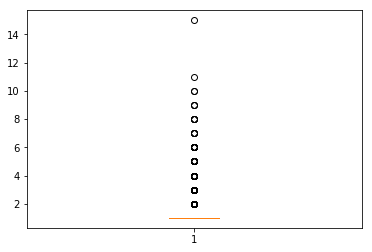

In [77]:
plt.boxplot(list(map(len,labels_t)))
plt.show()

### TMC
---
https://c3.nasa.gov/dashlink/resources/138/, 
https://catalog.data.gov/dataset/siam-2007-text-mining-competition-dataset

Revisar: https://github.com/Buzz-Beater/SIAM-2007-Text-Mining

### SearchSnipet
---
Dataset de Google search *snippets*-- pequeñas porciones de texto que le dan a usuarios una idea de lo que hay en el sitio web. Pertenecientes a 8 clases únicas (dominio).


2,280

http://jwebpro.sourceforge.net/data-web-snippets.tar.gz


### Reuters Corpus Volume 1
---
Corpus de Reuters extendido, con los 103 tópicos originales. Disponible en trabajos previos (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel.html) y a través de **sklearn**.


La representación son las *features* ya extraídas.

Probar este una vez ya experimentado con los pequeños anteriores


In [10]:
#https://scikit-learn.org/0.17/datasets/rcv1.html
from sklearn.datasets import fetch_rcv1
rcv1_train = fetch_rcv1(subset='train')
rcv1_test = fetch_rcv1(subset='test')
X_train = rcv1_train.data
y_train = rcv1_train.target
X_test = rcv1_test.data
y_test = rcv1_test.target

X_train

<23149x47236 sparse matrix of type '<class 'numpy.float64'>'
	with 1757801 stored elements in Compressed Sparse Row format>

In [11]:
X_train.shape

(23149, 47236)

In [13]:
y_test.shape

(781265, 103)

In [15]:
rcv1_train.target_names

array(['C11', 'C12', 'C13', 'C14', 'C15', 'C151', 'C1511', 'C152', 'C16',
       'C17', 'C171', 'C172', 'C173', 'C174', 'C18', 'C181', 'C182',
       'C183', 'C21', 'C22', 'C23', 'C24', 'C31', 'C311', 'C312', 'C313',
       'C32', 'C33', 'C331', 'C34', 'C41', 'C411', 'C42', 'CCAT', 'E11',
       'E12', 'E121', 'E13', 'E131', 'E132', 'E14', 'E141', 'E142',
       'E143', 'E21', 'E211', 'E212', 'E31', 'E311', 'E312', 'E313',
       'E41', 'E411', 'E51', 'E511', 'E512', 'E513', 'E61', 'E71', 'ECAT',
       'G15', 'G151', 'G152', 'G153', 'G154', 'G155', 'G156', 'G157',
       'G158', 'G159', 'GCAT', 'GCRIM', 'GDEF', 'GDIP', 'GDIS', 'GENT',
       'GENV', 'GFAS', 'GHEA', 'GJOB', 'GMIL', 'GOBIT', 'GODD', 'GPOL',
       'GPRO', 'GREL', 'GSCI', 'GSPO', 'GTOUR', 'GVIO', 'GVOTE', 'GWEA',
       'GWELF', 'M11', 'M12', 'M13', 'M131', 'M132', 'M14', 'M141',
       'M142', 'M143', 'MCAT'], dtype=object)

### Validation creation

In [3]:
from sklearn.model_selection import train_test_split
labels_t = np.asarray(labels_t)
labels_test = np.asarray(labels_test)
texts_train,texts_val,labels_train,labels_val  = train_test_split(texts_t,labels_t,random_state=20,test_size=0.25)
print("Cantidad de datos Entrenamiento: ",len(texts_train))
print("Cantidad de datos Validación: ",len(texts_val))
print("Cantidad de datos Pruebas: ",len(texts_test))

Cantidad de datos Entrenamiento:  8485
Cantidad de datos Validación:  2829
Cantidad de datos Pruebas:  7532


## Pre-process
---
Obtain the data representation


paper Variational Deep Semantic Hashing:
> "*Each dataset was split into three subsets with roughly 80% for training, 10% for validation, and 10% for test. The training data is used to learn the mapping from document to hash code. Each document in the test set is used to retrieve similar documents based on the mapping, and the results are evaluated. The validation set is used to choose the hyperparameters. We removed the stopwords using SMART’s list of 571 stopwords 5 . No stemming was performed. We use TFIDF [23] as the default term weighting scheme for the raw document representation (i.e., d). We experiment with other term weighting schemes in Section 5.4.*"

REvisar si este paper hace algo con la cantidad de features

Hinton: 
> "*We further preprocessed the data by removing common stopwords, stemming, and then only considering the 2000 most frequent words in the training dataset. As a result, each posting was represented as a vector containing 2000 word counts. No other preprocessing was done.*"



* Stemmed version (citado en 2 trabajos) -> http://web.ist.utl.pt/acardoso/datasets/  


Se experimenta con dos tipos de pre-procesamiento:

1. El primero es el siguiente: 
    * Pasar letras a minúsculas
    * Eliminar extra espacios (saltos de línea por ejemplo)
    * Remover stop words
    * Borrar todo lo que no sea letras (eliminar números y puntuaciones)
    * Conservar las top $k$ palabras/*tokens* más frecuentes
2. El segundo añade lo siguiente:
    * Se realiza un *stemming* (Snowball) -- Lemmatization
    * Remover palabras de menos de 3 largo



Para la representación se utiliza lo siguiente:
* TF-IDF: 
$$ w_f(d) \cdot \left(1 + log\left( \frac{1+n_d}{1+df_w} \right) \right)$$
* **TF (*term frecuency*)**: $$ w_f(d) $$
* Binary: $$I(w_f(d) \neq 0)$$

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
analyzer = TfidfVectorizer().build_analyzer()
stemmer = SnowballStemmer("english") 
lemmatizer = WordNetLemmatizer()

"""Extract features from raw input"""
def preProcess(s): #String processor
    return s.lower().strip().strip('-').strip('_')
def number_normalize(doc):
    results = []
    for token in analyzer(doc):
        token_pro = preProcess(token)
        if len(token_pro) != 0 and not token_pro[0].isdigit():
            results.append(token_pro)
    return results
def stemmed_words(doc):
    results = []
    for token in analyzer(doc):
        pre_pro = preProcess(token)
        #token_pro = stemmer.stem(pre_pro) #aumenta x10 el tiempo de procesamiento
        token_pro = lemmatizer.lemmatize(pre_pro) #so can explain/interpretae -- aumenta x5 el tiempo de proce
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results
        
mode = "default" #defaul is tf

smooth_idf_b = False
use_idf_b = False
binary_b = False
sublinear_tf_b = False

if mode == 'binary':
    binary_b = True
elif mode == 'tf':
    pass
elif mode == 'tf-idf':
    use_idf_b = True
    smooth_idf_b = True #inventa 1 conteo imaginario (como priors)--laplace smoothing
    #sublinear_tf_b = True #verificar: reemplaza tf por 1 + log(tf)
    
min_count = 5 #default = 1
max_feat = None #Best: 10000 -- Hinton (2000)
vectorizer = TfidfVectorizer(stop_words='english',analyzer=number_normalize,min_df=min_count, max_features=max_feat
                            ,binary=binary_b, use_idf=use_idf_b, smooth_idf=smooth_idf_b,sublinear_tf=sublinear_tf_b,norm=False) 
%time vectorizer.fit(texts_train)

vectors_train = vectorizer.transform(texts_train)
vectors_val = vectorizer.transform(texts_val)
vectors_test = vectorizer.transform(texts_train)
vectors_train.shape

CPU times: user 5.77 s, sys: 18.9 ms, total: 5.79 s
Wall time: 5.93 s


(8485, 20043)

vocabulario de 7mil en reuters,  10mil en newsgroup

In [5]:
token2idx = vectorizer.vocabulary_
idx2token = {idx:token for token,idx in token2idx.items()}
idx2token

{0: 'a',
 1: 'a0',
 2: 'a000',
 3: 'a1',
 4: 'a137490',
 5: 'a2',
 6: 'a2i',
 7: 'a3',
 8: 'a4',
 9: 'a5',
 10: 'a6',
 11: 'a7',
 12: 'a8',
 13: 'a86',
 14: 'a865',
 15: 'a9',
 16: 'a_rubin',
 17: 'aa',
 18: 'aa624',
 19: 'aa888',
 20: 'aaa',
 21: 'aamir',
 22: 'aardvark',
 23: 'aargh',
 24: 'aario',
 25: 'aaron',
 26: 'aas7',
 27: 'aau',
 28: 'ab',
 29: 'ab245',
 30: 'ab4z',
 31: 'ab961',
 32: 'abandon',
 33: 'abandoned',
 34: 'abbreviation',
 35: 'abc',
 36: 'abdominal',
 37: 'abdullah',
 38: 'aber',
 39: 'aberystwyth',
 40: 'abide',
 41: 'abiding',
 42: 'abilities',
 43: 'ability',
 44: 'able',
 45: 'abo',
 46: 'aboard',
 47: 'abode',
 48: 'abolish',
 49: 'abolished',
 50: 'abolition',
 51: 'abomination',
 52: 'abort',
 53: 'aborted',
 54: 'abortion',
 55: 'abortions',
 56: 'abound',
 57: 'about',
 58: 'above',
 59: 'abpsoft',
 60: 'abraham',
 61: 'abroad',
 62: 'abruptly',
 63: 'abs',
 64: 'absence',
 65: 'absent',
 66: 'absolute',
 67: 'absolutely',
 68: 'absolutes',
 69: 'absorb'

In [6]:
#todense --get representation
X_train = np.asarray(vectors_train.todense())
X_val = np.asarray(vectors_val.todense())
X_test = np.asarray(vectors_test.todense())
X_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

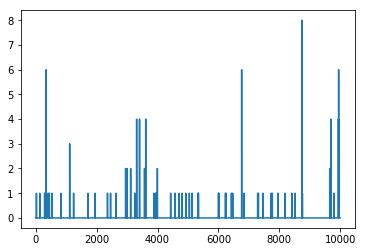

In [8]:
plt.plot(X_train[0])
plt.show()

### Model Architecture
---
Basado en Variational Deep Semantic Hashing, una arquitectura de autoencoder no simétrico:

> Input(|V|) -> Relu(500) -> Relu (500) -> Laten variable(32) (8-128)*2 -> Sampling -> Softmax(|V|)

Añadiendo una capa de *BatchNormalization* entre capas continuas.  

Tamién se experimenta con una arquitectura simétrica como se realiza en el trabajo de *Semantic Hashing*.


Fuentes:
* Tensorflow: https://github.com/unsuthee/VariationalDeepSemanticHashing/blob/master/VDSH.py
* PyTorch: https://github.com/unsuthee/SemanticHashingWeakSupervision

In [29]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    print("pre-encoder network:")
    pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    print("generator network:")
    generator.summary()
    
    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)

    def vae_loss(x, x_hat):
        reconstruction_loss = keras.losses.categorical_crossentropy(x, x_hat)*data_dim 
        #reconstruction_loss = keras.losses.binary_crossentropy(x, x_hat)*data_dim 

        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #con varianza
        return K.mean(reconstruction_loss  + kl_loss)

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt,loss=vae_loss)
    return traditional_vae,encoder,generator

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 500)               10022000  
_________________________________________________________________
batch_normalization_11 (Batc (None, 500)               2000      
_________________________________________________________________
dense_20 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_12 (Batc (None, 500)               2000      
Total params: 10,276,500
Trainable params: 10,274,500
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 20043)             661419    
Total params: 661,41

In [28]:
tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67

anneal_rate = 0.003
min_temperature = 0.5
tau_ann = K.variable(5.0, name="temperature") #o tau fijo en 0.67

def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)

class My_Callback(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(tau_ann, np.max([K.get_value(tau_ann) * np.exp(- anneal_rate * epoch), min_temperature])) 
        print(tau_ann.value().eval(session=keras.backend.get_session()))
        return

def binary_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    print("pre-encoder network:")
    pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    print("generator network:")
    generator.summary()

    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(p(b)/1-p(b))
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recuepra probabilidad
    #dist = Dense(Nb, activation='sigmoid')(hidden) #p(b) #otra forma de modelarlo
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)

    def gumbel_loss(x, x_hat):
        reconstruction_loss = keras.losses.categorical_crossentropy(x, x_hat)*data_dim

        dist = keras.activations.sigmoid(logits_b) #q(b)
        kl_disc_loss = Nb*np.log(2) + K.sum( dist*K.log(dist + K.epsilon()) + (1-dist)* K.log(1-dist + K.epsilon()),axis=1)
        return K.mean(reconstruction_loss  + kl_disc_loss)
    
    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=gumbel_loss)
    return binary_vae, encoder,generator

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 500)               10022000  
_________________________________________________________________
batch_normalization_9 (Batch (None, 500)               2000      
_________________________________________________________________
dense_17 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_10 (Batc (None, 500)               2000      
Total params: 10,276,500
Trainable params: 10,274,500
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 20043)             661419    
Total params: 661,41

In [94]:

    
hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val),callbacks=[My_Callback()])

Train on 8485 samples, validate on 2829 samples
Epoch 1/30
8485/8485 [==============================] - 7s 791us/step - loss: 2867268.4066 - val_loss: 2624300.0695
5.0
Epoch 2/30
8485/8485 [==============================] - 2s 183us/step - loss: 2608746.2675 - val_loss: 2580717.1983
4.9985003
Epoch 3/30
8485/8485 [==============================] - 2s 178us/step - loss: 2593678.1927 - val_loss: 2565837.7866
4.995502
Epoch 4/30
8485/8485 [==============================] - 2s 180us/step - loss: 2585310.4020 - val_loss: 2553509.8993
4.9910083
Epoch 5/30
8485/8485 [==============================] - 2s 181us/step - loss: 2576328.1292 - val_loss: 2539667.7664
4.9850225
Epoch 6/30
8485/8485 [==============================] - 2s 180us/step - loss: 2565788.7973 - val_loss: 2522615.5329
4.9775505
Epoch 7/30
8485/8485 [==============================] - 2s 179us/step - loss: 2553593.1666 - val_loss: 2506157.2019
4.968599
Epoch 8/30
8485/8485 [==============================] - 2s 177us/step - loss: 

In [173]:
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

Train on 8485 samples, validate on 2829 samples
Epoch 1/30
8485/8485 [==============================] - 10s 1ms/step - loss: 2303589.0000 - val_loss: 2093144.6778
Epoch 2/30
8485/8485 [==============================] - 2s 207us/step - loss: 2134144.0960 - val_loss: 2065488.4208
Epoch 3/30
8485/8485 [==============================] - 2s 207us/step - loss: 2123873.6284 - val_loss: 2059811.4621
Epoch 4/30
8485/8485 [==============================] - 2s 206us/step - loss: 2117614.7349 - val_loss: 2053973.6652
Epoch 5/30
8485/8485 [==============================] - 2s 208us/step - loss: 2111165.9506 - val_loss: 2046491.3832
Epoch 6/30
8485/8485 [==============================] - 2s 206us/step - loss: 2103237.1126 - val_loss: 2040416.9394
Epoch 7/30
8485/8485 [==============================] - 2s 203us/step - loss: 2096234.2720 - val_loss: 2034428.4132
Epoch 8/30
8485/8485 [==============================] - 2s 204us/step - loss: 2089633.5166 - val_loss: 2028480.6310
Epoch 9/30
8485/8485 [===

Primeras experimentaciones leves:
* Batch Normalization ayuda a estabilizar el entrenamiento
* Max *features* (*top k tokens*)  en características/representación fuciona mucho mejor que *min count*. Reduce el número de parámetros del modelo y también el *overfitting*
* Para representación de *Term Frecuency* es necesario normalizar: $\log{(tf+1)}$, mucho más estable el entrenamiento


### Train details
---

Deep Semantic Variational Hashing:
* Glorot initializer (Weights)
* Adam Optimizer (step size 0.001)
* Dropout (80%)-- overfitting
* 25-30 epochs
* batch size = 1 o 100

Semantic Hashing:
* Manual initializer (Weights) -- similar to as glorot
* Optimizer SGD (lr = 0.1, momentum 0.9, weight decay 0.0002)
* 50 epochs
* batch size de 100

MIO
* epochs aún no
* *batch size* de 100
* optimizador Adam
* Inicializador de Glorot (para los pesos)

In [8]:
batch_size = 100
epochs = 30

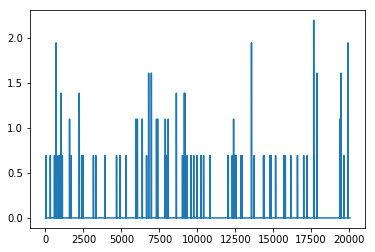

In [9]:
##representacion soft ---mucho mejor!
X_train_input = np.log(X_train+1)
X_val_input = np.log(X_val+1)
plt.plot(X_train_input[0])

In [10]:
hist1 = traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

Train on 8485 samples, validate on 2829 samples
Epoch 1/30
8485/8485 [==============================] - 14s 2ms/step - loss: 45397115.3659 - val_loss: 494804278.8194
Epoch 2/30
8485/8485 [==============================] - 5s 593us/step - loss: 40138632.0754 - val_loss: 2149413882222785.2500
Epoch 3/30
8485/8485 [==============================] - 5s 592us/step - loss: 39234523.3636 - val_loss: 37811106.3316
Epoch 4/30
8485/8485 [==============================] - 5s 591us/step - loss: 38683066.0082 - val_loss: 37598327.8699
Epoch 5/30
8485/8485 [==============================] - 5s 592us/step - loss: 37799200.4372 - val_loss: 38125794.6101
Epoch 6/30
8485/8485 [==============================] - 5s 595us/step - loss: 37793694.0177 - val_loss: 38102062.7246
Epoch 7/30
8485/8485 [==============================] - 5s 595us/step - loss: 37573461.3954 - val_loss: 36492573.9908
Epoch 8/30
8485/8485 [==============================] - 5s 593us/step - loss: 37121521.1243 - val_loss: 36496424.6674


In [15]:
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val))

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               10022000  
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
Total params: 10,276,500
Trainable params: 10,274,500
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20043)             661419    
Total params: 661,41

In [21]:
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=1000,layers_e=2,layers_d=0)
traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val))

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              20044000  
_________________________________________________________________
batch_normalization_5 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1000)              4000      
Total params: 21,053,000
Trainable params: 21,049,000
Non-trainable params: 4,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20043)             661419    
Total params: 661,41

In [30]:
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,BN=False)
traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=1
                           ,validation_data=(X_val,X_val))

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 500)               10022000  
_________________________________________________________________
dense_23 (Dense)             (None, 500)               250500    
Total params: 10,272,500
Trainable params: 10,272,500
Non-trainable params: 0
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 20043)             661419    
Total params: 661,419
Trainable params: 661,419
Non-trainable params: 0
_________________________________________________________________
Train on 8485 samples, validate on 2829 samples
Epoch 1/30
8485/8485 [==============================] - 145s 17ms/step - loss: nan - val_loss: nan
Epo

KeyboardInterrupt: 

In [ ]:
#con lemma?

In [ ]:
#borrar
plt.plot(traditional_vae.predict(X_train_input)[0])
plt.show()
plt.plot(X_train[0])

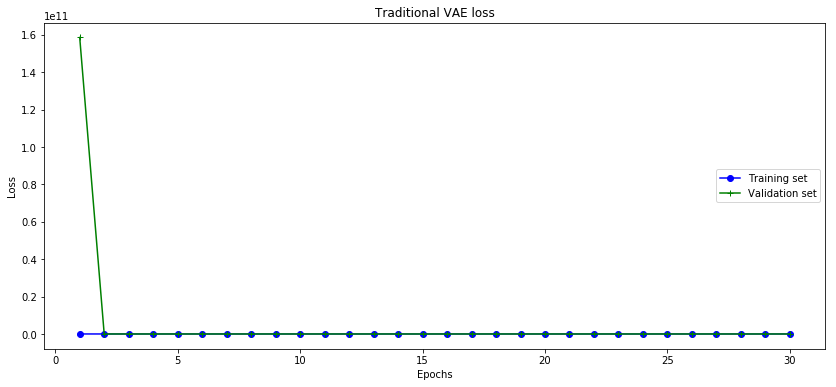

In [92]:
#curvas de entrenamiento
history_dict = hist1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs_l = range(1, len(loss_values) + 1)

plt.figure(figsize=(14,6))
plt.plot(epochs_l, loss_values, 'bo-', label = "Training set")
plt.plot(epochs_l, val_loss_values, 'g+-', label = "Validation set")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="center right", fancybox= True)
plt.title("Traditional VAE loss")
#plt.ylim(0,3000000)
plt.show()

In [13]:
hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

Train on 8485 samples, validate on 2829 samples
Epoch 1/30
8485/8485 [==============================] - 3s 306us/step - loss: 2313489.9991 - val_loss: 2101501.8897
Epoch 2/30
8485/8485 [==============================] - 1s 150us/step - loss: 2136042.7306 - val_loss: 2064270.9035
Epoch 3/30
8485/8485 [==============================] - 1s 148us/step - loss: 2123481.4937 - val_loss: 2062696.1438
Epoch 4/30
8485/8485 [==============================] - 1s 150us/step - loss: 2118019.8845 - val_loss: 2053668.2240
Epoch 5/30
8485/8485 [==============================] - 1s 150us/step - loss: 2109851.4440 - val_loss: 2045119.4543
Epoch 6/30
8485/8485 [==============================] - 1s 149us/step - loss: 2100582.7473 - val_loss: 2036244.6391
Epoch 7/30
8485/8485 [==============================] - 1s 148us/step - loss: 2091750.7668 - val_loss: 2028922.4808
Epoch 8/30
8485/8485 [==============================] - 1s 149us/step - loss: 2083681.3744 - val_loss: 2021511.3191
Epoch 9/30
8485/8485 [==

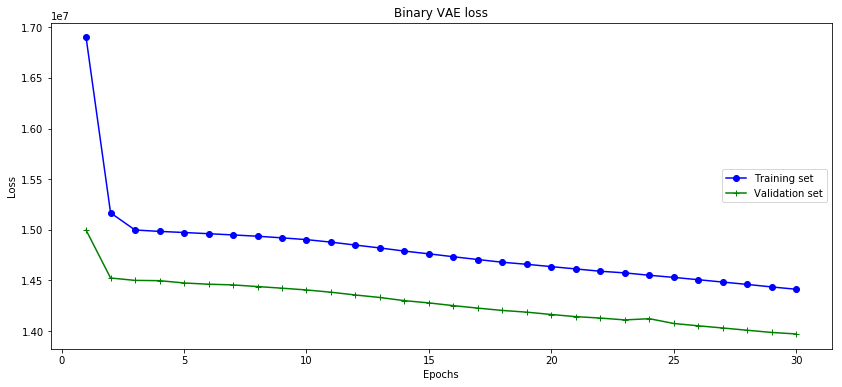

In [91]:
#curvas de entrenamiento
history_dict = hist2.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs_l = range(1, len(loss_values) + 1)

plt.figure(figsize=(14,6))
plt.plot(epochs_l, loss_values, 'bo-', label = "Training set")
plt.plot(epochs_l, val_loss_values, 'g+-', label = "Validation set")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="center right", fancybox= True)
plt.title("Binary VAE loss")
plt.show()

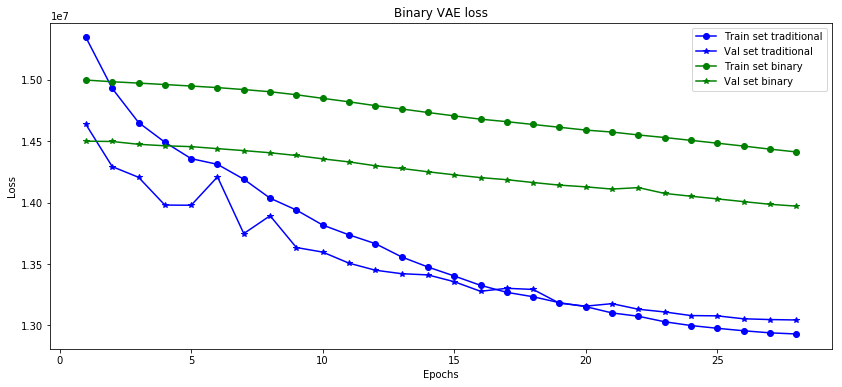

In [90]:
### binary vs traditional??
history_dict1 = hist1.history
history_dict2 = hist2.history
loss_values1 = history_dict1['loss'][2:]
val_loss_values1 = history_dict1['val_loss'][2:]
loss_values2 = history_dict2['loss'][2:]
val_loss_values2 = history_dict2['val_loss'][2:]
epochs_l = range(1, len(loss_values1) + 1)

plt.figure(figsize=(14,6))
plt.plot(epochs_l, loss_values1, 'bo-', label = "Train set traditional")
plt.plot(epochs_l, val_loss_values1, 'b*-', label = "Val set traditional")
plt.plot(epochs_l, loss_values2, 'go-', label = "Train set binary")
plt.plot(epochs_l, val_loss_values2, 'g*-', label = "Val set binary")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right", fancybox= True)
plt.title("Binary VAE loss")
#plt.ylim(1900000,2500000)

plt.show()

A través de las curvas de entrenamiento se puede ver que el vae tradicional le gana al binario en reconstrucción, lo cual resulta bastante lógico ya que tiene valores más libres en donde pueden vivir las variables (los reales) vs el binario que está mucho más restringido (entre 0 y 1).

### Results
---
Para evaluar los resultados y poder comparar es necesario realizar el proceso de evaluación que se detalla a continuación.

#### Proceso de evaluación
1. Calcular código hashing/binario de cada dato/documento
2. Recuperar documentos basado en *match* perfecto o *top K* de distancia *hamming*
3. Medir *precision* y *recall* en base a algún criterio de relevancia.

In [11]:
class MedianHashing(object):
    def __init__(self):
        self.threshold = None
        self.latent_dim = None
    def fit(self, X):
        self.threshold = np.median(X, axis=0)
        self.latent_dim = X.shape[1]
    def transform(self, X):
        assert(X.shape[1] == self.latent_dim)
        binary_code = np.zeros(X.shape)
        for i in range(self.latent_dim):
            binary_code[np.nonzero(X[:,i] < self.threshold[i]),i] = 0
            binary_code[np.nonzero(X[:,i] >= self.threshold[i]),i] = 1
        return binary_code.astype(int)
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
def get_similar(origen,destination,EM=True,K=100):
    """
        Retrieve similar documents to the origen document inside the destination corpus (source)
    """
    origen_similares = [] #indices
    for number,dato_hash in enumerate(origen):
        hamming_distance = np.sum(dato_hash != destination,axis=1) #distancia de hamming (# bits distintos)
        if EM: #match exacto
            origen_similares.append( np.where(hamming_distance==0)[0] )
        else: #topK
            ordenados = np.argsort(hamming_distance) #indices
            origen_similares.append(ordenados[:K]) 
        #ball radius?
        origen_similares[-1] = np.setdiff1d(origen_similares[-1] , np.asarray(number))
    return origen_similares

#build similar or compared in labels
def measure_metrics(data_similars,labels_data):
    #for now compare labels
    if type(labels_train[0]) == list:
        count_labels = {label:np.sum([label in aux for aux in labels_data]) for label in labels}
    else:
        count_labels = {label:np.sum(labels_data == label) for label in labels} #{label: labels_data.count(label) for label in labels}
    precision = 0.
    recall =0.
    for similars, label in zip(data_similars,labels_data): #source de donde se extrajo info
        if len(similars) == 0: #no encontro similares:
            continue
        labels_retrieve = labels_data[similars] 
        if type(labels_retrieve[0]) == list: #multiple classes
            tp = np.sum([len(set(label)& set(aux))>=1 for aux in labels_retrieve]) #al menos 1 clase en comun --quizas variar
            recall += tp/np.sum([count_labels[aux] for aux in label ]) #cuenta todos los label del dato
        else: #only one class
            tp = np.sum(labels_retrieve == label) #true positive
            recall += tp/count_labels[label]
        precision += tp/len(similars)
    
    return precision/len(labels_data), recall/len(labels_data)

In [22]:
#load vae, encoder and generator
encode_train = encoder_Tvae.predict(X_train_input)
encode_val = encoder_Tvae.predict(X_val_input)

#para VAE tradicional
median= MedianHashing()
median.fit(encode_train)

train_hash = median.transform(encode_train)
val_hash = median.transform(encode_val)
train_hash

array([[1, 0, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 1, 0, 1]])

In [17]:
encode_train = encoder_Bvae.predict(X_train_input) #logits
encode_val = encoder_Bvae.predict(X_val_input)

#para Binary VAE
probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
probas_val = keras.activations.sigmoid(encode_val).eval(session=K.get_session())

train_hash = (probas_train > 0.5)*1
val_hash = (probas_val > 0.5)*1
train_hash

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 1, 1, 1]])

In [19]:
val_similares_val =  get_similar(val_hash,val_hash,EM=True)
val_similares_val[:2]

[array([], dtype=int64), array([], dtype=int64)]

In [23]:
val_similares_val =  get_similar(val_hash,val_hash,EM=False,K=100)
val_similares_val[:2]

[array([  30,   34,  120,  121,  133,  140,  158,  163,  200,  204,  242,
         249,  253,  309,  332,  389,  410,  435,  530,  600,  606,  623,
         625,  640,  657,  684,  685,  693,  704,  779,  796,  812,  830,
         839,  847,  863,  866,  968,  971, 1023, 1039, 1049, 1074, 1077,
        1086, 1121, 1128, 1133, 1134, 1147, 1165, 1179, 1186, 1235, 1245,
        1303, 1310, 1318, 1333, 1336, 1362, 1367, 1368, 1382, 1457, 1475,
        1569, 1588, 1596, 1645, 1675, 1692, 1723, 1750, 1798, 1808, 1818,
        1824, 1905, 2016, 2020, 2044, 2077, 2129, 2217, 2253, 2296, 2338,
        2372, 2403, 2505, 2565, 2654, 2659, 2700, 2712, 2731, 2751, 2756]),
 array([   5,   26,   76,   80,  129,  169,  175,  192,  215,  233,  281,
         320,  353,  387,  393,  465,  477,  502,  504,  520,  521,  548,
         601,  652,  667,  734,  758,  759,  776,  783,  841,  868,  876,
         878,  880,  966,  989, 1017, 1036, 1057, 1070, 1081, 1091, 1107,
        1139, 1151, 1198, 1238, 1340

In [24]:
precision,recall = measure_metrics(val_similares_val,labels_val)
print("Precision (query: validation, source: validation) ",precision)
print("Recall    (query: validation, source: validation) ",recall)

Precision (query: validation, source: validation)  0.2371828929092948
Recall    (query: validation, source: validation)  0.1630839461310351


In [65]:
train_similares_train =  get_similar(train_hash,train_hash,EM=False,K=100)
precision,recall = measure_metrics(train_similares_train,labels_train)
print("Precision (query: train, source: train) ",precision)
print("Recall    (query: train, source: train) ",recall)

Precision (query: train, source: train)  0.324891817408018
Recall    (query: train, source: train)  0.07512756295147326


### Experimentación
---
A continación se realizan las experimentaciones correspondientes

In [14]:
def evaluate_hashing(encoder,train,val,labels_set,traditional=True):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    if traditional:
        median= MedianHashing()
        median.fit(encode_train)

        #train_hash = median.transform(encode_train)
        val_hash = median.transform(encode_val)
    else: #para Binary VAE
        #probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
        probas_val = keras.activations.sigmoid(encode_val).eval(session=K.get_session())

        #train_hash = (probas_train > 0.5)*1
        val_hash = (probas_val > 0.5)*1
        
    val_similares_val =  get_similar(val_hash,val_hash,EM=False,K=100) #or topK
    return measure_metrics(val_similares_val,labels_set)

In [67]:
sin_lemma_traditional = {}
sin_lemma_binary = {}
    
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

sin_lemma_traditional["precision"] = [p1, p2] 
sin_lemma_traditional["recall"] = [r1, r2]

                    
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

sin_lemma_binary["precision"] = [p1, p2] 
sin_lemma_binary["recall"] = [r1, r2]
print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_23 (Batc (None, 500)               2000      
_________________________________________________________________
dense_35 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_24 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10000)             330000    
Total params: 330,000


In [105]:
con_lemma_traditional = {}
con_lemma_binary = {}
    
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

con_lemma_traditional["precision"] = [p1, p2] 
con_lemma_traditional["recall"] = [r1, r2]

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

con_lemma_binary["precision"] = [p1, p2] 
con_lemma_binary["recall"] = [r1, r2]
print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_43 (Batc (None, 500)               2000      
_________________________________________________________________
dense_63 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_44 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 10000)             330000    
Total params: 330,000


In [106]:
print("Resultados de Precision en validación")

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_traditional["precision"]
t["Con Lemma"] = con_lemma_traditional["precision"]
print("\n*** VAE Traditional***")
print(t)

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_binary["precision"]
t["Con Lemma"] = con_lemma_binary["precision"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base  0.2798540370120401  0.2841565174544985
Simetrico 0.22855275983589507 0.27704046473929445

*** VAE Binary***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base 0.27538017145651994 0.31629122615336525
Simetrico   0.339728140364405   0.352853383606297


In [107]:
print("Resultados de Recall en validación")

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_traditional["recall"]
t["Con Lemma"] = con_lemma_traditional["recall"]
print("\n*** VAE Traditional***")
print(t)

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_binary["recall"]
t["Con Lemma"] = con_lemma_binary["recall"]
print("\n*** VAE Binary***")
print(t)

Resultados de Recall en validación

*** VAE Traditional***
               Sin Lemma          Con Lemma     
--------- ------------------- ------------------
     Base 0.19157503942601106 0.1935634800277119
Simetrico  0.1567055109236688 0.1890441069169437

*** VAE Binary***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base  0.1867768042416021 0.21653550976898298
Simetrico 0.23209726149925983 0.24124950620939722


En base a la experimentación anterior se encuentra con que aplicar *Lemmatization* a los *tokens* conlleva una mejora en ambas métricas (*precision* y *recall*), además de que utilizar una arquitectura simétrica (a pesar del incremento considerable de parámetros) conlleva una gran mejora en el *VAE* Binario.

In [23]:
#and what about stemming?
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_t,r_t = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_b,r_b = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

print("Terminó")

print("\nVAE tradicional ---\nPrecision %f -- Recall %f "%(p_t,r_t))
print("\nVAE binario ---\nPrecision %f -- Recall %f "%(p_b,r_b))

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_11 (Batc (None, 500)               2000      
_________________________________________________________________
dense_16 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_12 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 500)               16500     
______________________

In [ ]:
## measure test!

#para traditional vae
encode_test = encoder_Tvae.predict(X_test_input)
test_hash = median.transform(encode_test)

In [ ]:

if traditional:
    median= MedianHashing()
    median.fit(encode_train)

    train_hash = median.transform(encode_train)
    val_hash = median.transform(encode_val)
else: #para Binary VAE
    probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
    probas_val = keras.activations.sigmoid(encode_val).eval(session=K.get_session())

    train_hash = (probas_train > 0.5)*1
    val_hash = (probas_val > 0.5)*1


In [ ]:
test_similares_test =  get_similar(test_hash,test_hash,EM=True) #or topK
precision,recall = measure_metrics(test_similares_test,labels_test)
print("Precision (query: test, source: test) ",precision)
print("Recall    (query: test, source: test) ",recall)

### Analysis
---
Intepretar los códigos binarios en cada dataset

In [27]:
### best model.. train on train and val..
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)

encode_train = encoder_Bvae.predict(X_train_input) #logits
encode_val = encoder_Bvae.predict(X_val_input)

#para Binary VAE
probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
probas_val = keras.activations.sigmoid(encode_val).eval(session=K.get_session())

train_hash = (probas_train > 0.5)*1
val_hash = (probas_val > 0.5)*1
train_hash

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_19 (Batc (None, 500)               2000      
_________________________________________________________________
dense_26 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_20 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 500)               16500     
______________________

array([[0, 1, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 0, 1]])

In [19]:
##valores unicos de hash? distribucion de casillas
def hash_analysis(hash_data):
    hash_string = []
    for valor in hash_data:
        hash_string.append(str(valor)[1:-1].replace(' ',''))
    valores_unicos = set(hash_string)
    count_hash = {valor: hash_string.count(valor) for valor in valores_unicos}
    return valores_unicos, count_hash
valores_unicos, count_hash =  hash_analysis(train_hash)
print("Realizado")

Realizado


Cantidad de memorias en tabla hash:  4294967296
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  8485


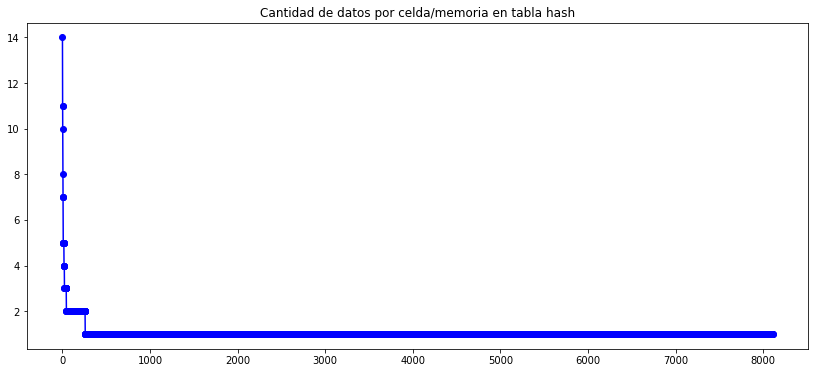

Cantidad de memorias ocupadas:  8108
Validación-----
Cantidad de datos a llenar la tabla hash:  2829


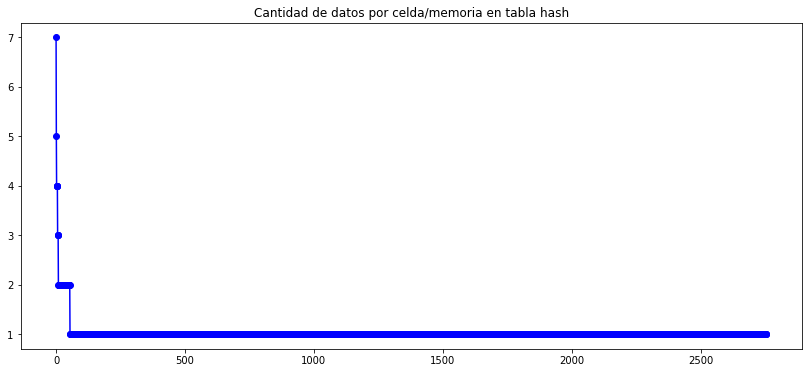

Cantidad de memorias ocupadas:  2756


In [20]:
print("Cantidad de memorias en tabla hash: ",2**train_hash.shape[1])

valores_unicos, count_hash =  hash_analysis(train_hash)
print("Entrenamiento----")
print("Cantidad de datos a llenar la tabla hash: ",train_hash.shape[0])
plt.figure(figsize=(14,6))
plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
plt.title("Cantidad de datos por celda/memoria en tabla hash")
#plt.xlim(-1)
plt.show()
print("Cantidad de memorias ocupadas: ",len(valores_unicos))

valores_unicos, count_hash =  hash_analysis(val_hash)
print("Validación-----")
print("Cantidad de datos a llenar la tabla hash: ",val_hash.shape[0])
plt.figure(figsize=(14,6))
plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
plt.title("Cantidad de datos por celda/memoria en tabla hash")
#plt.xlim(-1)
plt.show()
print("Cantidad de memorias ocupadas: ",len(valores_unicos))

se ocupan varias celdas de memorias gracias a la restricción de las variables latentes en el VAE

In [31]:
#generar un dato

#----- dada una probabilidad sobre el codigo
def sampling(aux):
    logits_b = K.log(aux/(1-aux) + K.epsilon() )
    b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
    return keras.activations.sigmoid( b/1 )

proba_b = np.random.rand(2,Nb).astype('float32')
b = sampling(proba_b).eval(session=K.get_session())

#----- dado un codigo binario
#b = np.ones((2,Nb))

reconstruct_data = generator_Bvae.predict(b)
reconstruct_data

array([[2.6172131e-06, 2.8746104e-05, 3.2126914e-06, ..., 1.0260586e-06,
        4.4227154e-06, 1.9489189e-06],
       [1.4434522e-05, 1.5676030e-04, 2.0504638e-05, ..., 2.2553264e-05,
        7.7611148e-06, 9.9000654e-06]], dtype=float32)

In [32]:
def get_topk_probably_words(probabilities,K):
    order_vocabulary =  np.argsort(probabilities) 
    tokens_probables = order_vocabulary[:K]  #token mas probables
    return list(map(lambda x:idx2token[x] ,tokens_probables))
Nb = generator_Bvae.input_shape[1]

get_topk_probably_words(reconstruct_data[0],5)

['glare', 'greec', 'grip', 'narrow', 'lmsc']

In [36]:
#----- dado un codigo binario
b = np.zeros((1,Nb))
b[0,0] = 1 #el primer bit

reconstruct_data = generator_Bvae.predict(b)
get_topk_probably_words(reconstruct_data[0],K=15)

['minist',
 'canal',
 'clas',
 'src',
 'hut',
 'etc',
 'hb9nbi',
 'steroid',
 'yell',
 'healthi',
 'kurd',
 'appropri',
 'telephon',
 'prayer',
 'sbc']

In [ ]:
#iterar sobre el resto de los bits y ver sus palabras mas frecuentes

In [ ]:
#combinar algunos para ver que pasa (los que se vean prometedores)